In [26]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
import os
import seaborn as sns
import pandas as pd
import math
import random
import imageio
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from scipy.optimize import curve_fit
from joblib import Parallel, delayed
plt.style.use(['science','ieee','no-latex'])

# get all the colors
import matplotlib.colors as mcolors

# MODELS

In [27]:
boundary_conditions = {0 : "PBC", 1:"OBC"}
print(matplotlib.get_configdir())
#plt.style.available

C:\Users\maxgr\.matplotlib


In [28]:
class IsingDisorder:
    N = 1
    M = 1
    def __init__(self, L, J, J0, g, g0, h, w, _BC):
        self.L = L
        self.J = J
        self.J0 = J0
        self.g=g
        self.g0=g0
        self.h=h
        self.w =w
        self.BC=_BC
        self.directory = "results" + kPSep
        self.N = math.pow(2,L)
        
    def getInfo(self):
        return f'L={self.L},J0={self.J0:.2f},g={self.g:.2f},g0={self.g0:.2f},h={self.h:.2f},w={self.w:.2f}' 


In [29]:
a=IsingDisorder(12,1,0,0.8,0,0.8,0.1,0)
a.getInfo()

NameError: name 'kPSep' is not defined

In [30]:
markers = itertools.cycle(['o','s','v', '+'])
colors_ls = list(mcolors.TABLEAU_COLORS)[:30]
colors = itertools.cycle(sns.color_palette()[:3])
TWOPI = math.pi * 2
kPSep = os.sep

disorder_pbc = f"..{kPSep}results{kPSep}disorder{kPSep}PBC{kPSep}"
symm_pbc = f"C:{kPSep}Users{kPSep}maxgr{kPSep}Desktop{kPSep}Wyniken{kPSep}results2_2{kPSep}symmetries{kPSep}PBC{kPSep}"
IsingPath = f"D:{kPSep}Uni{kPSep}SEMESTERS{kPSep}PRACE{kPSep}CONDENSED_GROUP_CLOUD_UNI{kPSep}Transverse_Ising{kPSep}Transverse_Ising_ETH{kPSep}"+\
    f"IsignTransverse_ETH"
IsingPath

'D:\\Uni\\SEMESTERS\\PRACE\\CONDENSED_GROUP_CLOUD_UNI\\Transverse_Ising\\Transverse_Ising_ETH\\IsignTransverse_ETH'

In [31]:
h=1.15
hstep = 0.02

hvalues = [h+i*hstep for i in range(3)]#+[1.4,1.42,1.45,1.47,1.5,1.55,1.57]
# perturbations
pert_vec = np.linspace(1e-3, 1e-2, 11);
pert_vec = np.append(pert_vec,np.linspace(1e-2, 3.9e-1, 20));
pert_vec,hvalues

(array([0.001 , 0.0019, 0.0028, 0.0037, 0.0046, 0.0055, 0.0064, 0.0073,
        0.0082, 0.0091, 0.01  , 0.01  , 0.03  , 0.05  , 0.07  , 0.09  ,
        0.11  , 0.13  , 0.15  , 0.17  , 0.19  , 0.21  , 0.23  , 0.25  ,
        0.27  , 0.29  , 0.31  , 0.33  , 0.35  , 0.37  , 0.39  ]),
 [1.15, 1.17, 1.19])

----------------------
# String separators and helper functions

### Concatenate list to a string given a separator
--------------

In [32]:
# Function to convert  
def listToString(s, separator = ","): 
    # initialize an empty string
    str1 = ""   
    # traverse in the string  
    for ele in s: 
        if isinstance(ele, (float,int)):
            str1 += "{:.3f}".format(ele) +separator 
        else:
            str1 += str(ele) +separator  
    
    # return string  
    return str1[:-1] 

### Creating a folder given a directory
-----------

In [33]:
def createFolder(directories, silent = False):
    for folder in directories:
        try:
            if not os.path.isdir(folder):
                os.makedirs(folder)
                if not silent:
                    print("Created a directory : ", folder)
        except OSError:
            print("Creation of the directory %s failed" % folder)      
# Guard against race condition
        except OSError as exc: 
            if exc.errno != errno.EEXIST:
                raise

### Reading random number from a folder given a condition
--------------

In [34]:
dat = lambda x : x.endswith('.dat')
def readRandomFile(folder, cond, withoutFolder = False):
    choice = random.choice(os.listdir(folder))
    #print(choice)
    maxlen = len(os.listdir(folder))
    counter = 0
    while not cond(choice):
        choice = random.choice(os.listdir(folder))
        if counter > maxlen:
            raise
        counter += 1
    if withoutFolder:
        return choice
    else:
        return folder + choice

### finding things in the list that are the same not to print them twice
----------

In [35]:
def findDifferentElementsStrings(listOfStrings):
    different = []
    the_same = []
    if len(listOfStrings) != 0:
        # create the intersection to distinguish same elements
        same = set(listOfStrings[0].split(","))
        #print(same)
        for i in range(1,len(listOfStrings)):
            tmp = set(listOfStrings[i].split(","))
            same = same.intersection(tmp)
            #print(same)
        # after having the intersection find the list of names to put into legend that are different
        for i in range(0, len(listOfStrings)):
            tmp = set(listOfStrings[i].split(",")) - same
            different.append(listToString(tmp))
        the_same = list(same)
    # return same and list of different strings in the form of tuple
    return (listToString(np.sort(the_same)), different)

findDifferentElementsStrings(["g=1,h=2,w=3,a=1,pert=0.2", "g=1,h=3,w=4,a=1,pert=0.2","g=1,h=2,w=4,a=2,pert=0.2"])

('g=1,pert=0.2', ['w=3,h=2,a=1', 'h=3,w=4,a=1', 'w=4,h=2,a=2'])

### Print to file with adjusting column width

In [36]:
def justPrinter(file,sep="\t", elements =[], width = 8, endline = True):
    for item in elements:
        file.write((str(item) + sep).ljust(width))
    if endline:
        file.write("\n")

#### return list of axes

In [37]:
def listOfAxis(num, figsize = (10,10), dpi = 100):
    fig, ax = plt.subplots(num, figsize=(10,10), dpi = 100)
    sns.set_style("ticks")
    # set axis for it to always be a list
    axis = []
    if num > 1: # if we have many columns to plot
        axis = [ax[i] for i in range(num)]
    else:
        axis = [ax]
    return fig, axis

------------
## IMAGES AND ETC.

#### make gif

In [38]:
def makegif(directory, name, distinguishers, images,fps=1.0):
    folder = f'{directory}plots{kPSep}' 
    kwargs_write = {'fps':fps, 'quantizer':'nq'}
    imageio.mimsave(folder + f'{name}_{listToString(distinguishers)}.gif', images, fps=1)

#### make axis style for image

In [39]:
def setPlotElems(ax, xlabel, ylabel, xscale, yscale, legend = True, leg_names = [], font_size = 8.5, xlim =[], ylim=[]):
    ax.set(xlabel = xlabel, ylabel = ylabel)
    ax.set_yscale(yscale)
    ax.set_xscale(xscale)
    
    if legend:
        ax.legend(leg_names
                , frameon=False
                , loc='best'
                , fontsize=font_size)
    
    xmin, xmax = xlim
    ymin, ymax = ylim
    if xmin != None and xmax != None:
        ax.set_xlim([xmin,xmax])
    if ymin != None and ymax != None:
        ax.set_ylim([ymin, ymax])

-------------------------
# Handle all the files starting from a given name given by the user and distinguished by the parameters and return the list of dataframes

In [40]:
def check_header(filename):
    with open(filename) as f:
        first = f.read(1)
        return first not in '.-0123456789'

### Fit functions
---------

In [41]:
def poisson_fit(x, lambd):
    return lambd * np.exp(-lambd * np.abs(x))
    
def laplace_fit(x, lambd,mu):
    return np.exp(-np.abs(x - mu)/lambd)/(2*lambd)

def exponential_fit(x, lambd,sigma):
    return sigma * np.exp(-lambd * np.abs(x))

def gauss_fit(x, mu, sigma):
    return np.exp(-0.5*np.power(x-mu,2)/(sigma*sigma))/(sigma*math.sqrt(2*np.pi))

def linear_fit(x,a,b):
    return a*x+b

fitDic = {
    poisson_fit : ('poisson','$\lambda$*exp(-$\lambda$x):' ,'$\lambda$='),
    laplace_fit : ('laplace','exp(-|x-$\mu$|/$\lambda$)/2$\lambda$:',"$\mu$=",'$\lambda$='),
    exponential_fit : ('exponential','$\sigma$*exp(-$\lambda$x):', '$\sigma$=', '$\lambda$=' ),
    gauss_fit : ('gaussian','exp(-$(x-\mu)^2$/2($\sigma^2$))/($\sigma$*$\sqrt{2\pi}$):', '$\mu$=', '$\sigma$=' ),
    linear_fit : ('linear', 'a*x+b:', 'a=', 'b=')
}
fitDic

{<function __main__.poisson_fit(x, lambd)>: ('poisson',
  '$\\lambda$*exp(-$\\lambda$x):',
  '$\\lambda$='),
 <function __main__.laplace_fit(x, lambd, mu)>: ('laplace',
  'exp(-|x-$\\mu$|/$\\lambda$)/2$\\lambda$:',
  '$\\mu$=',
  '$\\lambda$='),
 <function __main__.exponential_fit(x, lambd, sigma)>: ('exponential',
  '$\\sigma$*exp(-$\\lambda$x):',
  '$\\sigma$=',
  '$\\lambda$='),
 <function __main__.gauss_fit(x, mu, sigma)>: ('gaussian',
  'exp(-$(x-\\mu)^2$/2($\\sigma^2$))/($\\sigma$*$\\sqrt{2\\pi}$):',
  '$\\mu$=',
  '$\\sigma$='),
 <function __main__.linear_fit(x, a, b)>: ('linear', 'a*x+b:', 'a=', 'b=')}

##### distinguish between different fits and append it to the legend list

In [42]:
def addFitFunction(fitFun, appendList, popt, chi_p_value):
    tmp = fitDic[fitFun]
    fitname = tmp[0] + ',' + tmp[1]
    counter = 0
    for param in tmp[2:]:
        appendList.append(f'{param}' + "{:.3f}".format(popt[counter]))
        counter += 1
    appendList.append(f'\nChi={chi_p_value:.3f}')
    return fitname

##### fit to dataframe from dataframe

In [43]:
def fitToDataframe(fitFun, x, y):
    # fit curve
    xdata = np.array(x)
    ydata = np.array(y)
    popt, pcov = curve_fit(fitFun, x, ydata)
    predict = np.array(fitFun(xdata, *popt))
    
    ydataChi = ydata / np.sum(ydata)
    popt2, pcov2 = curve_fit(fitFun, x, ydataChi)
    predictChi = np.array(fitFun(xdata, *popt2))
    predictChi = predictChi / np.sum(predictChi)
    
    #print(np.sum(ydataChi),np.sum(predictChi))
    chi, pval_chi = stats.chisquare(f_obs=ydataChi, f_exp=predictChi)
    return popt, chi, pd.DataFrame(predict)

-----------
### Give dataframes from files

In [44]:
def handle_all_files(directory, file_begin, columns, distinguishers, separator = "\t\t", fitfunctions = []):
    # columns is a list of tuples of column number and its name [(0:...)] etc -> 0 is an idx
    dfs = []
    # make fit before
       
    
    for filename in os.listdir(directory):
        if filename[-4:] != ".dat" or not filename.startswith(file_begin):
            continue
        # split the name and the parameters
        splitter = filename[:-4].split("_")
        # split each of the parameters 
        params = splitter[-1].split(",")
        skip = False
        
        for element in distinguishers:
            in_bucket = False
            # check elements in each element_bucket
            for bucket in element:
                if bucket in params:
                    in_bucket = True
            # if none of possible parameters from individual bucket is in params => skip
            if not in_bucket:
                skip = True
                break
                
        if not skip or len(distinguishers) == 0:
            skip_rows = 0
            # check if there is a header present already
            if check_header(directory + filename):
                skip_rows = 1
            tmp = pd.read_csv(directory + filename, sep = separator, header=None, skiprows = skip_rows, index_col = 0)

            # check if nan's are in and skip that column if all are nans
            tmp = tmp.loc[:,tmp.notna().all(axis=0)]
            # if there is still something to read then read!
            if len(columns) > 0:
                names = [column[0] for column in columns]
                numbers = [column[1] for column in columns]
                
                # take everything except the index
                tmp = tmp[numbers[1:]]
                tmp.columns = names[1:]
            # append new df to a list of dataframes with its params   
            dfs.append((tmp, listToString(params)))
            for fitFun in fitfunctions:
                # always take the first column for the fit
                popt,chi, fit_df = fitToDataframe(fitFun, tmp.index, tmp[columns[1][0]])
                fit_df.index = tmp.index
                # add labels
                params_fit = []
                fitname = addFitFunction(fitFun, params_fit,popt, chi)
                name,function  = fitname.split(',')
                params_fit = [function] + params_fit + [name]
                #print(params_fit)
                # append to dataframes
                dfs.append((fit_df, f'{listToString(params_fit,separator=":")},{listToString(params,separator=",")}'))    
    #print(dfs)
    return dfs

tmp = handle_all_files(symm_pbc, "perturbationOperatorsDist", columns = [("$S^x_p$ - $S^x_{p+dp}$", 0), ("$P(S^x_p-S^x_{p+dp})$", 1)]\
                       , distinguishers = [["h=1.35"],["g=0.80"],['pert=0.0010']], fitfunctions = [gauss_fit])
#tmp

# Operators plotter as a function of energies, plots all elements connecting files with parameters present in the distinguisher

In [45]:
def plot_av_operator_dfs(directory, file_begin, columns, distinguishers, operator_name,\
                         scale_x = "linear", scale_y = "linear",chi_squared = False,\
                         separator = "\t\t", fitfunctions = [],gif = False,save_files=True,\
                         xmin = -0.05, xmax = 0.05, ymin = 0.01, ymax = 100):
    # clean plot    
    plt.clf()
    plt.cla()
    
    fitter = []
    for fitFun in fitfunctions:
        fitter.append(fitDic[fitFun][0])
        
    # save in folder
    folder = f'{directory}plots{kPSep}' 
    createFolder([folder])
    #print(directory)
    # find the list of dataframes
    a = handle_all_files(directory, file_begin, columns, distinguishers, separator = separator, fitfunctions = fitfunctions)
    if len(a) == 0:
        return
    else:
        #unpack
        listOfDf = [item[0] for item in a]
        labels = ([item[1] for item in a])
        
    #print(labels)
    # create number of figures to be plotted
    fig, axis = listOfAxis(len(columns) - 1, figsize=(10,10), dpi = 100)

    # for files
    same_and_diff = findDifferentElementsStrings(labels)
    savefile = file_begin + "_" + same_and_diff[0]
    
    # plot
    colorki = [next(colors) for i in range(len(listOfDf))]
    markerki = [next(markers) for i in range(len(listOfDf))]
    
    # iterate over dataframes
    df_iter = 0
    for df in listOfDf:
        itr = 0
        for col in df.columns:
            df[col].plot(ax = axis[itr]
                    , linewidth=0.5
                    , marker=markerki[df_iter]
                    , markersize=1.8
                    , color = colorki[df_iter])
            itr+=1
        df_iter += 1
    #print("same_and_diff is:",np.sort(same_and_diff[1]))
    # set the style
    for i in range(len(columns) - 1):
        
        setPlotElems(axis[i], columns[0][0],
                     columns[i+1][0], xscale = scale_x, yscale=scale_y,
                     legend = len(listOfDf) > 1, 
                     leg_names = same_and_diff[1],
                     font_size = 8.5,
                     xlim =[xmin,xmax], ylim=[ymin,ymax])

    
    # add title
    fig.suptitle(operator_name + " for " + same_and_diff[0], y=0.91)
    # set fitfunctions
    # GIF
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    if gif:
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close()
    if save_files:
        fits = ".png"
        if(len(fitfunctions) > 0):
            fits = f',{listToString(fitter,",")}{fits}'
            #print(fits)
        plt.savefig(f'{folder + savefile},scale_y={scale_y},scale_x={scale_x }{fits}')
        plt.show()
        plt.close()

            
    #
    return image
   

In [48]:
# sigma_x                    
#plot_av_operator_dfs(symm_pbc, "SigmaX",columns = [("E/L",0), ("<n|$S_x$|n>",1)], distinguishers = [], operator_name = "<n|$S_x$|n>") 
# sigma_x prob dist
#plot_av_operator_dfs(symm_pbc, "ProbDistSigmaX",columns = [("$S^x_{nn}$", 0), ("P($S^x_{nn}$)",1)], distinguishers = [["L=18"],["g=0.80"], ["h=1.00","h=1.50"]],
#                      operator_name = "Probability distribution of $S^x_{nn}$", scale_y = 'log', fitfunctions = []) 
# sigma x repulsion
#plot_av_operator_dfs(symm_pbc, "ProbDistSpecRapSigmaX",columns = [("$S^x_{nn} - $S^x_{n-1,n-1}$", 0), ("P(r)",1)],
 #distinguishers = [["L=19","L=18", "L=17", "L=16"],["g=0.8"], ["h=1.00"]], operator_name = "("$S^x_{nn} - $S^x_{n-1,n-1}$", 0), ("P(r)",1)", scale_y = 'linear', separator = '\t')
# sigma x prob dist all sectors
#plot_av_operator_dfs(symm_pbc, "ProbDistSpecRapSigmaXAllSectors",columns = [("$S^x_{nn} - $S^x_{n-1,n-1}$", 0), ("P(r)",1)],
 #distinguishers = [], operator_name = "P(r) for all sectors", scale_y = 'linear', separator = '\t\t') 

# energy difference
#plot_av_operator_dfs(symm_pbc + "/EnergyDiff/", "perturbationEnergyDiffDist",columns = [("E-E'", 0), ("P(E-E')",1)], 
#                     distinguishers = [["L=18"],["g=0.80"], ["h=1.80"], ["pert=0.0100", "pert=0.0300", "pert=0.1100", "pert=0.1500"]],
#                     operator_name = "P(E-E')", scale_y = 'log', fitfunctions =[], xmin = -0.25, xmax = 0.25) 
# operators dist


    

In [49]:
for hval in hvalues:    
    images = []
    for i in pert_vec:
        #print(i)
        #im = plot_av_operator_dfs(symm_pbc, "perturbationOperatorsDist",columns = [("$S^x_p$ - $S^x_{p+dp}$", 0), ("$P(S^x_p-S^x_{p+dp})$", 1)],
                        #distinguishers = [["L=18"],["g=0.80"], [f"h={hval:.2f}"], [f"pert={i:.4f}"]],
                        #operator_name = "Probability distribution with perturbation", scale_y ="log",\
                         #fitfunctions=[laplace_fit, gauss_fit],gif=True,save_files = False,\
                         #xmin = -0.1, xmax = 0.1, ymin = 0.1, ymax = 500) 
        #images.append(im)     
    #makegif(symm_pbc, "perturbationOperatorsDist$S^x$", [["L=18"],["g=0.80"], [f"h={hval:.2f}"]], images)

SyntaxError: unexpected EOF while parsing (Temp/ipykernel_8824/4091695942.py, line 11)

In [50]:

for i in pert_vec[5:17]:
    print(i)
    images = []
    for hval in hvalues:    
        
        print(hval)
        #im = plot_av_operator_dfs(symm_pbc, "perturbationOperatorsDist",columns = [("$S^x_p$ - $S^x_{p+dp}$", 0), ("$P(S^x_p-S^x_{p+dp})$", 1)],
                        distinguishers = [["L=18"],["g=0.80"], [f"h={hval:.2f}"], [f"pert={i:.4f}"]],
                        operator_name = "Probability distribution with perturbation", scale_y ="log",\
                         fitfunctions=[laplace_fit, gauss_fit],gif=True,save_files = False,\
                         xmin = -0.1, xmax = 0.1, ymin = 0.1, ymax = 500)
        if(len(im)>0):
            images.append(im)
        
    makegif(symm_pbc, "perturbationOperatorsDist$S^x$", [["L=18"],["g=0.80"], [f"pert={i:.4f}"]], images)




#ipr scaling with h
#plot_av_operator_dfs(symm_pbc, "IprScaling",columns = [("h", 0), ("ipr", 1), ("Information entropy", 2), ("$r_{goe}$",3)], distinguishers = [["L=18"],["g=1.20","g=0.80", "g=0.40"]], operator_name = "System scaling with h")
# moments of probability sigma_x fluct
#plot_av_operator_dfs(symm_pbc, "Moments",columns = [("h", 0), ("$U_B$", 1), ("Kurtossis", 2), ("$\sigma$",3)], distinguishers = [["L=18"],["g=1.20","g=0.80"]], operator_name = "System scaling with h")

IndentationError: unexpected indent (Temp/ipykernel_8824/3500389758.py, line 8)

## Plot only distributions in different files

In [51]:
def plot_distribution(directory, file_begin, columns, distinguishers, distribution_name, column_num = [], separator = "\t\t"):
    try:
        folder = 'plots/' + directory 
        if not os.path.isdir(folder):
            os.makedirs(folder)
    except OSError:
        print("Creation of the directory %s failed" % (folder))
    else:
        sns.set_style("ticks")
        # find the list of dataframes
        listOfDf = handle_all_files(directory, file_begin,columns, distinguishers, column_num, separator)
        labels = [item[1] for item in listOfDf]
        same_and_diff = findDifferentElementsStrings(labels)
        
        # plot 
        counter = 0
        for df in listOfDf:
            savefile = file_begin + "_" + same_and_diff[0] + "," + labels[counter]
            fig, ax = plt.subplots(len(columns) - 1, figsize=(12,8), dpi = 120) 
            axis = []
            if len(columns) > 2: # if we have many columns to plot
                axis = [ax[i] for i in range(len(columns) - 1)]
            else:
                axis = [ax]
            
            step = 0.01
            _min = np.min(df[0].index)
            _max = np.max(df[0].index)
            new_ticks = [_min + step * i for i in range(0, int((_max-_min)/step) + 1)]
            print(new_ticks)
            itr = 0
            for col in df[0].columns:      

                df[0][col].plot.bar(ax = axis[itr], rot=15, color = next(colors))
                axis[itr].set(title = distribution_name + " for " + same_and_diff[0] + "," + same_and_diff[1][counter]
                            ,xlabel = col
                            ,ylabel = distribution_name)
                #axis[itr].get_legend().remove()
                #(same_and_diff
                #            , frameon=False
                #            , loc='best'
                #            , fontsize=8)
                axis[itr].set_xticks(np.interp(new_ticks, df[0].index, np.arange(df[0].size)))
                axis[itr].set_xticklabels(new_ticks)
                itr+=1
            counter+=1
            plt.savefig(folder + savefile + ".pdf")
            plt.savefig(folder + savefile + ".png")
            plt.show()


#plot_distribution(symm_pbc, "ProbDistSpecRapSigmaX", columns = ["P(|r|)", "<n + 1|$S_x$|n + 1> - <n|$S_x$|n>"], distinguishers = [], distribution_name= "P(|r|)", separator = "\t")

# PLOT HEATMAP

In [52]:
def plot_heat_map(destination, filename, columns, separator = "\t"):
    # save in folder
    df = pd.read_csv(f"{destination}{filename}", sep = separator, header=None)
    df = df.dropna(axis = 1)
    #mapka
    df.columns = columns
    #return df    
    #df.set_index([columns[0], columns[1]], inplace = True)
    #cols = df.columns
    #df[cols[0]] = df[cols[0]].replace('  nan',0)
    
    
    #print(df)
    
    
    fig, ax = plt.subplots(figsize=(12,10), dpi = 100)
    savefile = f"{destination}{filename[0:-4]}.pdf"

    #print(cols)

    #pivotted = df.pivot(cols[0])
    # PLOT 
    z = np.array(df.loc[:,columns[2]])
    z = np.array([0 if i == '  nan' else float(i) for i in z])
    #print(z)
    x = np.array(df.loc[:,columns[0]])
    x = np.unique(x)
    print(x)
    y = np.array(df.loc[:,columns[1]])
    y = np.unique(y)
    print(y)

    X,Y = np.meshgrid(y,x)

    Z=z.reshape(len(x),len(y))

    heatmap = plt.pcolormesh(X,Y,Z,cmap='coolwarm',vmin=np.min(z), vmax=1 )
    #pivotted = df.pivot(x,y,z)
    #print(pivotted)
    #
    #mini = np.min(z)
    #maxi = np.max(z)
    ##print(mini,maxi)
    #sns.heatmap(X,Y,Z,cmap='coolwarm',vmin=np.min(z), vmax=np.max(z))
    ##sns.heatmap(pivotted,cmap='coolwarm',vmin=np.min(z), vmax=np.max(z))
    if(len(columns) == 3):
        plt.xlabel(columns[1])
        plt.ylabel(columns[0])
        
    ##ax.set_zscale([0.35,0.535])
    plt.title(f"{columns[2]} for different lattent dimensions and transverse field disorder strength\n\
    $δg$ in (g+δg) * $S_x$")
    #plt.legend()
    fig.colorbar(heatmap)
    plt.savefig(savefile)
    plt.show()
    plt.close()


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9]
[0.00488 0.11523 0.22559 0.33643 0.44678 0.55762 0.66797 0.77881 0.88916
 1.     ]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


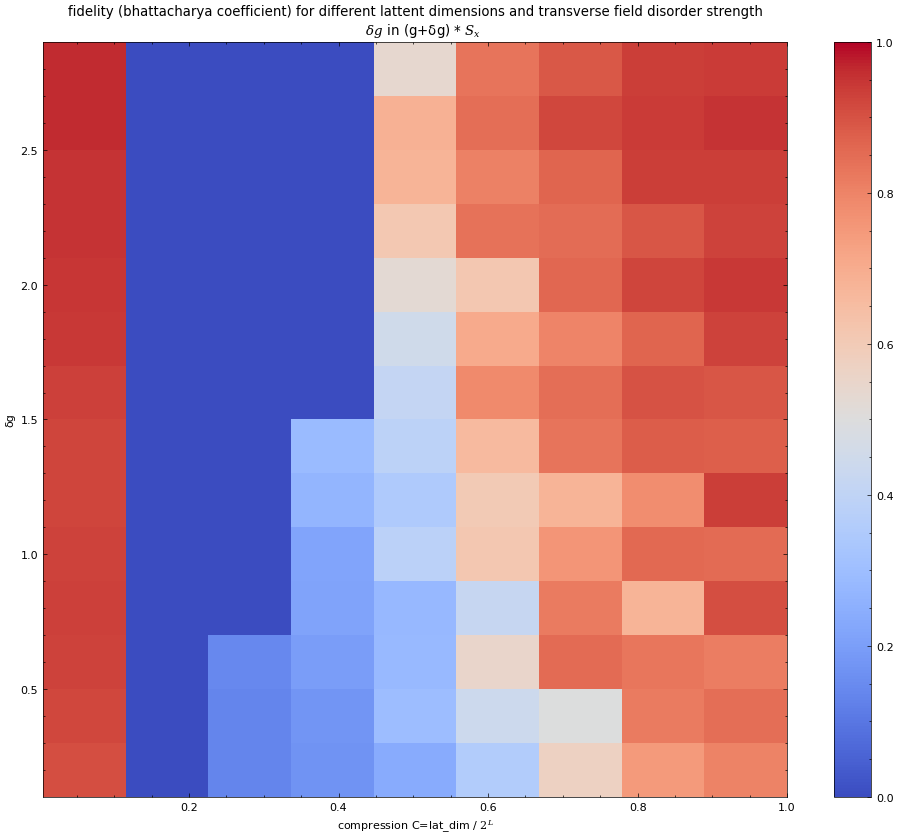

In [53]:
destination = f"C:{kPSep}Users{kPSep}maxgr{kPSep}Desktop{kPSep}Wyniken{kPSep}WAVES{kPSep}"
plot_heat_map(destination, "heatmap_layernum=2.txt", ["δg","compression C=lat_dim / $2^L$", "fidelity (bhattacharya coefficient)"])

# ENTROPY

In [54]:
def informationEntropy(stateA, statesB, N, sqrt = False):
    ent = 0
    for stateB in statesB:
        c_k = 0
        if not sqrt:
            c_k = np.dot(stateA, (stateB))
        else:
            for i in range(N):
                c_k += math.sqrt(stateA[i]) *math.sqrt(stateB[i])
                
        val = abs(c_k)
        ent += val * math.log(val)
    return -ent / math.log(0.48 * N)

In [55]:
def theirFidelity(probaA, probaB):
    # first state
    mini, maxi = np.min(probaA), np.max(probaA)
    #print(mini,maxi)
    h =2* (np.quantile(probaA,0.75) - np.quantile(probaA,0.25)) * math.pow(len(probaA),-1/2)
    bins = [mini + i * h for i in range(int((maxi - mini)/h))]
    #print(bins)
    
    f1, b1 = np.histogram(probaA, density=True, bins=bins)
    #plt.hist(probaA, density=True, bins=b1)
    # second state
    f2, b2= np.histogram(probaB, density = True, bins = b1)
    #plt.hist(probaB, density=True, bins=b1)
    
    f1/=f1.sum()
    f2/=f2.sum()
    return np.sum(np.sqrt(np.multiply(f1, f2)))

probaA = np.array([0.3602150537634409, 0.42028985507246375, 
  0.373117033603708, 0.36813186813186816, 0.32517482517482516, 
  0.4175257731958763, 0.41025641025641024, 0.39408866995073893, 
  0.4143222506393862, 0.34, 0.391025641025641, 0.3130841121495327, 
  0.35398230088495575])
probaA /= np.sum(probaA)

probaB = np.array([0.3602150537634409, 0.42028985507246375, 
  0.373117033603708,
  0.463, 0.41025641025641024, 0.39408866995073893, 
  0.406393862, 0.34, 0.391025641025641, 0.3130841121495327, 
  0.35398230088495575])
probaB /= np.sum(probaB)


theirFidelity(np.array(probaA), np.array(probaB))

0.7559289460184544

# NETWORKS

In [56]:
# import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
from keras.metrics import MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError
from keras.callbacks import History
from keras import callbacks
from keras import losses
from keras import Input, Model
from keras import regularizers
from keras import initializers, optimizers
from plot_keras_history import plot_history
from tqdm.keras import TqdmCallback
from sklearn.model_selection import train_test_split


# tensorflow
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.utils import plot_model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, Rescaling
print(device_lib.list_local_devices())

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5389786863362994243
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5060693856
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16378740401165130101
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [57]:
# PYTORCH
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
torch.cuda.empty_cache() 

## AUTOENCODER KERAS

In [58]:
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [59]:
def autoEnc(latent_dim, shape, nlayers = 1, alfa = 0.1): 
    print(f"creating {nlayers} with input shape {shape}")
    input_size = shape[1]
    compression = int(input_size * latent_dim / input_size)
    reduction = compression // nlayers
    if input_size - (nlayers-1)*reduction <= 0:
        print(f"to many layers {nlayers} for compression {compression}")
    
    
    # ------ encoder
    inputer = None
    encoder = None
    if nlayers == 1:
        inputer = Input(input_size)
        #shap = (None 
        encoder = layers.Dense(input_size - (nlayers - 1)*reduction,\
                       activation=keras.activations.sigmoid)(inputer)
        # we must have size bigger than 0 so check maximum for those number of layers
    else:
        # add linear layer
        inputer = Input(input_size)
        encoder = layers.Dense(input_size - reduction,\
                                   activation = layers.LeakyReLU(alpha = alfa))(inputer)
        # add leaky relus
        counter = 2
        for i in range(nlayers - 3):
            encoder = layers.Dense(input_size - counter * reduction,\
                                   activation = layers.LeakyReLU(alpha = alfa))(encoder)
            counter += 1
        
        # add last dense layer
        encoder = layers.Dense(input_size - (nlayers - 1)*reduction,\
                               activation=keras.activations.sigmoid)(encoder)
 
    
    # --------- Latent log variance and mu layers    
    fc_logvar = layers.Dense(latent_dim, name = "log_var")(encoder)
    fc_mu = layers.Dense(latent_dim, name = "mean")(encoder)
    fc = Sampling()([fc_mu, fc_logvar])
    encod = keras.Model(inputer, [fc_mu, fc_logvar, fc], name="encoder")
    encod.summary()
    
    
    # ------ decoder
    inputer = keras.Input(latent_dim)
    decoder = None
    if nlayers == 1:
        decoder = layers.Dense(input_size, activation = keras.activations.sigmoid)(inputer)
        # we must have size bigger than 0 so check maximum for those number of layers
    else:
        counter = nlayers - 1
        decoder = layers.Dense(input_size - counter * reduction,\
                               activation = layers.LeakyReLU( alpha = alfa))(inputer)
        
        counter -= 1
        for i in range(nlayers - 2):
            decoder = layers.Dense(input_size - counter * reduction,\
                                   activation = layers.LeakyReLU( alpha = alfa))(decoder)
            counter -= 1

        # add last dense layer
        decoder = layers.Dense(input_size, activation=keras.activations.sigmoid)(decoder)        
    
    decod = keras.Model(inputer, decoder, name="decoder")
    decod.summary()
    
    return encod,decod

### Variational nn class keras

In [60]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder,epochs, **kwargs):
        super(VAE, self).__init__(**kwargs)
        # LOG AND MEAN ARE IN THE ENCODER ALREADY
        self.epochs = epochs
        self.epoch = 0
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction)
                )
            )
            weight = 0.85 * (self.epoch / self.epochs)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss * weight  #* self.weight
        
            #print(f"with weight = {self.weight} and {total_loss}")    
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.total_loss_tracker.update_state(total_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    def scheduler(self, epoch, lr):

        self.epoch = epoch

        #print(self.weight)
        return lr#self.weight
    def call(self, x):
        x = self.encoder(x)
        return self.decoder(x)
    

## AUTOENCODER PYTORCH

In [61]:
class Print(nn.Module):
    """
    Used to print the shape of the data inside of nn.Sequential
    """

    def __init__(self):
        super(Print, self).__init__()

    def forward(self, x):
        print(x.shape)
        return x

In [62]:
def get_layers(input_size, n_layers, compression):
    
    reduction = compression // n_layers
    encoder = None
    # These if statements determine the structure of the VAE dependent on the desired compression
    print(input_size, reduction)
    if n_layers == 1:
        # Desired structure for 1 total layer in the encoder
        encoder = nn.Sequential(nn.Sigmoid())
    elif n_layers == 2:
        # Desired structure for 2 total layers in the encoder
        encoder = nn.Sequential(
            nn.Linear(input_size, input_size - reduction),
            nn.Sigmoid()
        )
    elif n_layers == 3:
        # Desired structure for 3 total layers in the encoder
        encoder = nn.Sequential(
            nn.Linear(input_size, input_size - reduction),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction,
                      input_size - reduction * 2),
            nn.Sigmoid()
        )
    elif n_layers == 4:
        # Desired structure for 4 total layers in the encoder
        encoder = nn.Sequential(
            nn.Linear(input_size, input_size - reduction),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction,
                      input_size - reduction * 2),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 2,
                      input_size - reduction * 3),
            nn.Sigmoid()
        )
    elif n_layers == 5:
        # Desired structure for 5 total layers in the encoder
        encoder = nn.Sequential(
            nn.Linear(input_size, input_size - reduction),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction,
                      input_size - reduction * 2),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 2,
                      input_size - reduction * 3),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 3,
                      input_size - reduction * 4),
            nn.Sigmoid()
        )
    elif n_layers == 6:
        # Desired structure for 6 total layers in the encoder
        encoder = nn.Sequential(
            nn.Linear(input_size, input_size - reduction),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction,
                      input_size - reduction * 2),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 2,
                      input_size - reduction * 3),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 3,
                      input_size - reduction * 4),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 4,
                      input_size - reduction * 5),
            nn.Sigmoid()
        )
    elif n_layers == 7:
        # Desired structure for 7 total layers in the encoder
        encoder = nn.Sequential(
            nn.Linear(input_size, input_size - reduction),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction,
                      input_size - reduction * 2),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 2,
                      input_size - reduction * 3),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 3,
                      input_size - reduction * 4),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 4,
                      input_size - reduction * 5),
            nn.Linear(input_size - reduction * 5,
                      input_size - reduction * 6),
            nn.Sigmoid()
        )

    decoder = None

    if n_layers == 7:
        # Desired structure for 7 total layers in the decoder
        decoder = nn.Sequential(
            nn.Linear(compression, input_size - reduction * (n_layers - 1)),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 6,
                      input_size - reduction * 5),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 5,
                      input_size - reduction * 4),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 4,
                      input_size - reduction * 3),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 3,
                      input_size - reduction * 2),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 2,
                      input_size - reduction * 1),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 1, input_size),
            nn.Sigmoid()
        )
    elif (n_layers == 6):
        # Desired structure for 6 total layers in the decoder
        decoder = nn.Sequential(
            nn.Linear(compression, input_size - reduction * (n_layers - 1)),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 5,
                      input_size - reduction * 4),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 4,
                      input_size - reduction * 3),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 3,
                      input_size - reduction * 2),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 2,
                      input_size - reduction * 1),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 1, input_size),
            nn.Sigmoid()
        )
    elif (n_layers == 5):
        # Desired structure for 5 total layers in the decoder
        decoder = nn.Sequential(
            nn.Linear(compression, input_size - reduction * (n_layers - 1)),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 4,
                      input_size - reduction * 3),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 3,
                      input_size - reduction * 2),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 2,
                      input_size - reduction * 1),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 1, input_size),
            nn.Sigmoid()
        )
    elif n_layers == 4:
        # Desired structure for 4 total layers in the decoder
        decoder = nn.Sequential(
            nn.Linear(compression, input_size - reduction * (n_layers - 1)),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 3,
                      input_size - reduction * 2),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 2,
                      input_size - reduction * 1),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 1, input_size),
            nn.Sigmoid()
        )
    elif n_layers == 3:
        # Desired structure for 3 total layers in the decoder
        decoder = nn.Sequential(
            nn.Linear(compression, input_size - reduction * (n_layers - 1)),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 2,
                      input_size - reduction * 1),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 1, input_size),
            nn.Sigmoid()
        )
    elif n_layers == 2:
        # Desired structure for 2 total layers in the decoder
        decoder = nn.Sequential(
            nn.Linear(compression, input_size - reduction * (n_layers - 1)),
            nn.LeakyReLU(0.20),
            nn.Linear(input_size - reduction * 1, input_size),
            nn.Sigmoid()
        )
    elif n_layers == 1:
        # Desired structure for 1 total layer in the decoder
        decoder = nn.Sequential(
            nn.Linear(input_size - reduction * 1, input_size),
            nn.Sigmoid()
        )

    # Latent log variance and mu layers
    fc_logvar = nn.Linear(input_size - reduction * (n_layers - 1), compression)
    fc_mu = nn.Linear(input_size - reduction * (n_layers - 1), compression)



    return {'decoder': decoder, 'encoder': encoder, 'logvar': fc_logvar, 'mu': fc_mu}

### load file from folder like dataset

In [63]:
# Define your own class LoadFromFolder
class FromFolder(Dataset):
    def __init__(self, main_dir, filenum = None):
         
        # Set the loading directory
        self.main_dir = main_dir
        # List all images in folder and count them
        all_files = list(filter(lambda x: x.endswith('.dat'), os.listdir(self.main_dir)))
        if filenum != None:
            all_files = all_files[0:filenum]
        self.total_files = sorted(all_files)
    def __len__(self):
        # Return the previously computed number of images
        return len(self.total_files)   
    def __getitem__(self, idx):
        loc = os.path.join(self.main_dir, self.total_files[idx])
        fil = np.square(np.genfromtxt(loc))       
        return fil
    


## Model class in torch

In [72]:
class Modelik:
    def __init__(self, parameters, data_path, lat_dim, verbosity=0, n_layers=3, n_qubits=8,trainsize=0.9,filenum = None, load=None):
        """
        Args:
            parameters: dict of json params
            n_layers: number of layers in the encoder/decoder
            n_qubits: number of lattice sites
            load: optional path to load a pretrained model
        """
        # Initialize class parameteres
        torch.cuda.empty_cache()
        
        self.n_layers = n_layers
        self.n_qubits = n_qubits
        self.N = int(math.pow(2, self.n_qubits))
        self.lat_dim = lat_dim
        self.compression = self.lat_dim / self.N
        
        self.epochs = int(parameters['epochs'])
        self.batch_size = int(parameters['batch_size'])
        self.trainsize = trainsize
        self.display_epochs = int(parameters['display_epoch'])
        self.learning_rate = parameters['learning_rate']
        self.num_batches = int(parameters['num_batches'])
        self.data_path = data_path
        self.filenum = filenum


        self.device = torch.device(
            'cuda' if torch.cuda.is_available() else 'cpu')
        self.verbosity = verbosity
        
        self.savename = self.data_path + f'..{kPSep}myModel_latent={self.lat_dim},{self.N}'

        # Prepare model
        self.vae, self.train_loaders, self.test_loaders, self.optimizer = self.prepare_model(
            load=load)

        # Train the model if it wasn't loaded, and compute fidelity
        if load == None:
            train_losses, test_losses = self.run_model()
            self.plot_losses(train_losses, test_losses)
        
        
        #print(self.train_loaders.dataset)
        self.fidelity = self.get_fidelity(self.train_loaders)

    def prepare_model(self, load=None):
        """
        Initializes VAE model and loads it onto the appropriate device.
        Reads and loads the data in the form of an array of Torch DataLoaders.
        Initializes Adam optimizer.
        Args:
            load: path to load trained model from
        Returns:
            VAE
            Array of train Torch Dataloaders
            Array of test Torch Dataloaders
            Adam optimizer
        Raises:
        """
        input_size = self.N
        VAE_layers = get_layers(input_size, self.n_layers, self.lat_dim)
        
        vae = VariationalAutoencoder(VAE_layers.get('encoder'), VAE_layers.get(
            'decoder'), VAE_layers.get('logvar'), VAE_layers.get('mu')).double().to(self.device)
        
        train_loaders, test_loaders = self.get_data(self.batch_size, self.data_path)
    
        optimizer = optim.Adam(vae.parameters(), lr=self.learning_rate)

        if not load == None:
            vae.load_state_dict(torch.load(load))
            vae.eval()

        return vae, train_loaders, test_loaders, optimizer

    def loss_function(self, x, x_reconstruction, mu, log_var, weight=1):
        """
        Returns the loss for the model based on the reconstruction likelihood and KL divergence
        Args:
            x: Input data
            x_reconstruction: Reconstructed data
            mu:
            log_var:
            weight:
        Returns:
            loss:
        Raises:
        """
        reconstruction_likelihood = F.binary_cross_entropy(
            x_reconstruction, x, reduction='sum')
        kl_divergence = -0.5 * \
                        torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        loss = reconstruction_likelihood + kl_divergence * weight

        return loss

    def get_fidelity(self, x):
        """
        Calculates the reconstruction fidelity.
        
        Args:
            x: Input data
        Returns:
            out: Fidelity for the input sample
        Raises:
        """
        #self.vae.eval()
        #torch.no_grad()
        fidel = 0
        counter = 0

        x = x.dataset
        #x = x.dot(1 << np.arange(x.shape[-1] - 1, -1, -1))  # Converts binary string to integer
        print(x)
        
        l, u = x.min(), x.max() + 1
        f1, b = np.histogram(x, density=True, bins=np.arange(l, u, 1))
        
        # Initialize for getting reconstructed density
        f2 = np.zeros(f1.shape)
        ns = 0
        dim = int(self.n_qubits * self.compression)
        while ns < 10:
            # Get samples, decode them, convert to int, and add to hist count
            re = np.random.multivariate_normal(
                np.zeros(dim), np.eye(dim), size=int(0.375e7))
            re = self.vae.decode(torch.Tensor(re).double().to(
                self.device)).cpu().detach().numpy()
            f2 += np.histogram(re, bins=b)[0]
            ns += 1
        
        #with torch.no_grad():
        #    for i, data in enumerate(x):
        #        if i >= self.num_batches:
        #            break
#
        #        #print(data)
        #        tmp = data.to(self.device)
        #        reconstruction_data, mu, logvar = self.vae(tmp)
        #        reconstruction_data = reconstruction_data.cpu()
        #        #print(reconstruction_data)
        #        for e in range(len(reconstruction_data)):
        #            a = reconstruction_data[e].numpy()
        #            b = data[e].numpy()
        #            fidel += theirFidelity(a, b)
        #            counter+=1
        
        db = np.array(np.diff(b), float)
        f2 = f2 / db / f2.sum()

        out = np.sum(np.sqrt(np.multiply(f1, f2)))
        print(f"Fidelity: {out}")
        del re, x_re, f1, f2, x
        
        torch.cuda.empty_cache()
        return out #fidel/counter

    def train(self, epoch, loader):
        """
        Trains the VAE model
        Args:
            epoch: Number of current epoch to print
            loader: Torch DataLoader for a quantum state
        Returns:
            epoch_loss: Loss for the epoch
        Raises:
        """
        self.vae.train()
        epoch_loss = 0

        for i, data in enumerate(loader):

            if i >= self.num_batches:
                break

            data = data.to(self.device)
            self.optimizer.zero_grad()
            reconstruction_data, mu, log_var = self.vae(data)
            
            loss = self.loss_function(
                data, reconstruction_data, mu, log_var, weight=0.85 * (epoch / self.epochs))
            loss.backward()
            epoch_loss += loss.item() / (data.size(0) * self.num_batches)
            self.optimizer.step()

            if (self.verbosity == 0 or (
                    self.verbosity == 1 and (epoch + 1) % self.display_epochs == 0)) and i % self.batch_size == 0:
                print("Done batch: " + str(i) +
                      "\tCurr Loss: " + str(epoch_loss))

        if self.verbosity == 0 or (self.verbosity == 1 and (epoch + 1) % self.display_epochs == 0):
            print('Epoch [{}/{}]'.format(epoch + 1, self.epochs) +
                  '\tLoss: {:.4f}'.format(epoch_loss)
                  )

        return epoch_loss

    def test(self, epoch, loader):
        """
        Tests VAE model
        Args:
            epoch: Number of current epoch to print
            loader: Torch DataLoader for a quantum state
        Returns:
            epoch_loss: Loss for the epoch
        Raises:
        """
        self.vae.eval()
        epoch_loss = 0

        with torch.no_grad():
            for i, data in enumerate(loader):

                if i >= self.num_batches:
                    break

                data = data.to(self.device)
                reconstruction_data, mu, logvar = self.vae(data)
                loss = self.loss_function(
                    data, reconstruction_data, mu, logvar)
                epoch_loss += loss.item() / (data.size(0) * self.num_batches)

        return epoch_loss

    def run_model(self):
        """
        Args:
            state: Quantum state the model will be trained on
        Returns:
            test and training loss
        Raises:
        """

        train_loader, test_loader = self.train_loaders, self.test_loaders
        train_losses, test_losses = [], []

        print("Beginning Training:")
        for e in range(0, self.epochs):
            train_loss = self.train(e, train_loader)
            test_loss = self.test(e, test_loader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)

        print(f"Final train loss: {train_loss}\tFinal test loss: {test_loss}")

        #torch.save(self.vae.state_dict(),self.savename)

        return train_losses, test_losses

    def plot_losses(self, train_losses, test_losses):
        """
        Args:
            train_losses: list of training losses from run_model
            test_losses: list of testing losses from run_model
        Returns:
        Raises:
        """
        savename=self.savename
        epochs = np.arange(0, len(train_losses), 1)
        plt.plot(epochs, train_losses, "g-", label="Training Loss")
        plt.plot(epochs, test_losses, "b-", label="Testing Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"VAE Training Loss with {self.n_layers} layers")
        plt.legend()
        plt.xlim(0, len(train_losses))
        
        figure_num = 1
        while os.path.exists(f'{savename}_loss_{figure_num}.png'):
            figure_num += 1
        plt.savefig(f'{savename}_loss_{figure_num}.png')
        plt.clf()
        print(f'{savename}_loss_{figure_num}.png')

    def plot_fidelities(self, fs):
        """
        Args:
            fs: A list of Fidelities from each model
        Returns:
        Raises:
        """
        
        savename=self.savename
        epochs = np.arange(1, len(fs) + 1, 1)
        plt.plot(epochs, fs, "b--o", label="Fidelity")
        plt.xlabel("Layers")
        plt.xticks(ticks=epochs)
        plt.ylabel("Fidelity")
        plt.title("VAE Fidelities")
        plt.xlim(epochs.min(), epochs.max())
        
        
        figure_num = 1
        while os.path.exists(f'{savename}_fidelity_{figure_num}.png'):
            figure_num += 1
        plt.savefig(f'{savename}_fidelity_{figure_num}.png')
        plt.clf()
        print(f'{savename}_fidelity_{figure_num}.png')
        
        
    
    def get_data(self, batch_size, file_path):
        """
        Args:
            batch_size: Size of batches
            file_path: Path of file location
        Returns:
            train_loaders: Array of Torch DataLoaders representing quantum states for training
            test_loaders: Array of Torch DataLoaders representing quantum states for testing
        Raises:
        """
        ds = FromFolder(file_path, self.filenum)
        num = ds.__len__()
        num_train = int(num * self.trainsize)
        train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(ds, (num_train, num - num_train, 0))
        
        train_loaders  = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True)
        test_loaders  = torch.utils.data.DataLoader(
            valid_dataset, batch_size=batch_size, shuffle=True)
        return train_loaders, test_loaders

### Variational nn class pytorch

In [73]:
class VariationalAutoencoder(nn.Module):
    """
    Variational Autoencoder class.
    Architecture:
        - x Fully connected layers
        - Sigmoid activation function
        - LeakyReLU activation function with slope of -0.2
    """

    def __init__(self, encode, decode, logvar, mu):
        """
        Very standard VAE, all the heavy lifting done elsewhere
        Args:
            encode: encoder input from hidden_layers
            decode: decoder layers
            logvar: logvar layer
            mu:mu layer
        """

        super(VariationalAutoencoder, self).__init__()
        self.LReLU = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

        self.fc_logvar = logvar
        self.fc_mu = mu

        self.encode = encode
        self.decode = decode

    def encoder(self, x):
        x = self.encode(x)
        return self.fc_mu(x), self.fc_logvar(x)

    def decoder(self, x):
        x = self.decode(x)
        return x

    @staticmethod
    def reparameterize(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        x = self.reparameterize(mu, logvar)
        reconstruction = self.decoder(x)
        return reconstruction, mu, logvar

# TEST FUNCTIONS

In [74]:
def fileAutoencode(directory, model, latent_dim, epo,layer_num, trainsize = 0.8,filenum = None, batch = 10, verbose = 2,\
                   activation = 'relu', savename = 'model', save = True, savefiles = False):
    folderLog = directory + "_" + model.getInfo() + kPSep
    folder = folderLog + "wavefunctions" + kPSep
    folderSaveNew = folderLog + "wavefunctions_encoder" + kPSep
    createFolder([folderSaveNew])
    savename = folderLog + f'myModel_latent={latent_dim/model.N:.3f}'
    # read files
    wavefuns = []
    
    files = list(filter(lambda x: x.endswith('.dat'), os.listdir(folder)))
    maximum = len(files)
    if filenum != None:
        maximum = filenum
    

    counter = 0
    # create squares of the wavefunctions
    for filename in files:
        tmp = np.square(np.genfromtxt(folder+filename))
        wavefuns.append(tmp)
        if counter == maximum:
            break
        counter+=1
    
    x_train, x_valid, y_train, y_valid = train_test_split(wavefuns, wavefuns, test_size=1-trainsize, shuffle= True)
    tmp = np.concatenate([x_train, y_train])
    
    #print(x_train, y_train)
    # separate training etc
    #data_train = np.array(wavefuns[0:int(trainsize*maximum)])
    #data_test = np.array(wavefuns[int(trainsize*maximum):])
    #print(data_test)
    
    print(f'\n\n\t\tMaking autoencoder with latent={latent_dim/model.N}\t\t\n\n')    
    encoder, decoder = autoEnc(latent_dim, (None, int(modelik.N)),layer_num, alfa = 0.2)
    vae = VAE(encoder, decoder, epo)
    # first model compile
    vae.compile(optimizer=keras.optimizers.Adam(lr=1e-3))
    vae.build((None, int(modelik.N)))
    
    #story = vae.fit(tmp,
    #epochs=1,
   #shuffle=False,
    #batch_size = batch,
    #verbose=0)
    
    vae.summary()
    
    
    
    
    # making callbacks
    early_stopping_cb = callbacks.EarlyStopping(monitor="loss", patience=3)
    callback = [early_stopping_cb]
    if save:
        callback.append(keras.callbacks.ModelCheckpoint(savename + ".h5", save_best_only=True))
    if verbose == 2:
        callback.append(TqdmCallback(verbose = verbose))
    
    # define number of iterations in training and test
    train_iter = round(np.array(x_train).shape[0]/batch)
    test_iter = round(np.array(x_valid).shape[0]/batch)
    
    # make artificial history
    history = {}
    history['history'] = {}
    history['history']['total_loss'] = []
    history['history']['reconstruction_loss'] = []
    history['history']['kl_loss'] = []   
    
    tot_loss, reconstr_loss, kl_loss = 0, 0, 0
    for ep in range(epo):
        vae.epoch = ep
        vae.compile(optimizer=keras.optimizers.Adam(lr=1e-3))
        # train iterations
        for i in range(train_iter):
            start = i*batch
            end = i*batch + batch
            batchX = np.array(x_train[start:end]).astype('float32')
            
            #batchY = np.array(y_train[start:end]).astype('float32')
            #print(batchX.shape)
            #tmp = np.concatenate([batchX, batchY])
            #tmp = np.expand_dims(tmp, -1).astype("float32")
            print(batchX, batchX.shape)

           #story = vae.fit(tmp,
           #  epochs=1,
           #  shuffle=False,
           #  batch_size = batch,
           #  verbose=0,
           #  callbacks = callback)
            tot_loss_,reconstr_loss_,kl_loss_ = vae.train_on_batch(batchX)
            #print(dic)
            #tot_loss_ = dic['loss']
            #reconstr_loss_ = dic['reconstruction_loss'] 
            #kl_loss_ = dic['kl_loss']

            #print(tot_loss_, reconstr_loss_, kl_loss_)
            tot_loss += tot_loss_
            reconstr_loss += reconstr_loss_
            kl_loss += kl_loss_
        history['history']['total_loss'].append(tot_loss/train_iter)
        history['history']['reconstruction_loss'].append(reconstr_loss/train_iter)
        history['history']['kl_loss'].append(kl_loss/train_iter)    
        
        # test iterations 
        #val_tot_loss, val_reconstr_loss, val_kl_loss = 0, 0, 0
        #for i in range(test_iter):
        #    start = i*batch
        #    end = i*batch + batch
        #    batchX = np.array(x_valid[start:end]).astype('float32')
        #    batchY = np.array(y_valid[start:end]).astype('float32')
        #    
        #    tmp = np.concatenate([batchX, batchY], axis = 0)
        #    #tmp = np.expand_dims(tmp, -1).astype("float32")
        #    #istory = vae.fit(tmp,
        #    #   epochs=1,
        #    #   shuffle=False,
        #    #   batch_size = batch,
        #    #   verbose=0,
        #    #   callbacks = callback)
##
        #    dic =vae.test_step([tmp])
        #    val_tot_loss_ = dic['val_loss']
        #    val_reconstr_loss_ = dic['val_reconstruction_loss'] 
        #    val_kl_loss_ = dic['val_kl_loss']
    #
    #
        #    val_tot_loss += val_tot_loss_
        #    val_reconstr_loss += val_reconstr_loss_
        #    val_kl_loss += val_kl_loss_
        #history['history']['val_total_loss'].append(val_tot_loss/test_iter)
        #history['history']['val_reconstruction_loss'].append(val_reconstr_loss/test_iter)
        #history['history']['val_kl_loss'].append(val_kl_loss/test_iter)  
        
        
        
        

        #histories.append(history)
    
    
    # save file h5
    if save:
        print("\t\t---->creating h5 file: " + savename + ".h5")
        vae.save(savename + ".h5", save_format='h5')
    
            #print(history.history)
    #validation_data=(data_test,data_test)
    # plot model
    print(history['history']['total_loss'])
    
    #plot_history(history, path=savename+',training.png')
    
    counter = 0
    fidelity = 0
    # save new files
    if savefiles:
        for file in wavefuns:
            name = f"{counter}_wavefun__{model.getInfo()}.txt"
            # predict probabilities
            tmp = np.array(vae.decoder.predict(np.array([file]))[0])
            #print(tmp-file)

            # save to file
            fil = open(folderSaveNew + name, "wb")
            np.save(fil, tmp)
            fil.close()

            fidelity += theirFidelity(tmp, file)
            if counter == maximum:
                break
            counter+=1
    else:
        for i in np.random.randint(len(wavefuns), size=batch):
            file = wavefuns[i]
            
            # predict probabilities
            tmp = np.array(vae.encoder.predict(np.array([file]))[0])
            tmp = np.array(vae.decoder.predict([tmp])[0])
            #print(file, tmp, "\n\n\n")
            
            # fidelity
            fidelity += theirFidelity(tmp, file)
            if counter == maximum:
                break
            counter+=1
            
    return vae, fidelity/counter#,entropy_before/counter, entropy/counter

# LOOPS

In [75]:
destination = f"{IsingPath}{kPSep}resultsWAVE5{kPSep}disorder{kPSep}PBC{kPSep}"
modelik = IsingDisorder(12,1,0,0.8,0,0.83,0.1,0)
N=modelik.N
L = 12
latent_dims = np.linspace(5, N, 30)
ws = np.array([0.1*i for i in range(1,2)])
epo = 10
batch = 10
filenum = 10
layer_num = 2
# for pytorch mode
parameters = {"epochs" : epo, 'batch_size' : batch, 'display_epoch' : 5, 'learning_rate' : 1e-3, 'num_batches':batch}

ws, latent_dims, destination

(array([0.1]),
 array([   5.        ,  146.06896552,  287.13793103,  428.20689655,
         569.27586207,  710.34482759,  851.4137931 ,  992.48275862,
        1133.55172414, 1274.62068966, 1415.68965517, 1556.75862069,
        1697.82758621, 1838.89655172, 1979.96551724, 2121.03448276,
        2262.10344828, 2403.17241379, 2544.24137931, 2685.31034483,
        2826.37931034, 2967.44827586, 3108.51724138, 3249.5862069 ,
        3390.65517241, 3531.72413793, 3672.79310345, 3813.86206897,
        3954.93103448, 4096.        ]),
 'D:\\Uni\\SEMESTERS\\PRACE\\CONDENSED_GROUP_CLOUD_UNI\\Transverse_Ising\\Transverse_Ising_ETH\\IsignTransverse_ETH\\resultsWAVE5\\disorder\\PBC\\')

In [79]:

for layer_num in range(3,4):
    with open(destination + f"heatmap_layernum={layer_num},filenum={filenum},L={L},epo={epo},batch={batch}.txt", "w") as mapka:
        for w in ws:
            modelik = IsingDisorder(L,1,0,0.8,0,0.83,w,0)
            N=modelik.N
            folderLog = destination + "_" + modelik.getInfo() + kPSep
            folder = folderLog + "wavefunctions" + kPSep
            
            for lat_dim in latent_dims:
                modelik2 = Modelik(parameters, folder, lat_dim = int(lat_dim), verbosity=0,
                                   n_layers=layer_num,
                                   n_qubits=L,filenum = filenum,
                                   load=None)
                #enc,fidelity = fileAutoencode(destination, modelik, int(lat_dim), epo,
                #                              layer_num=layer_num,
                #                              filenum=filenum,batch=batch,
                #                              verbose = 0,
                #                              save = False, savefiles = False)
                fid = modelik2.fidelity
                justPrinter(mapka, "\t", [f"{w:.2f}", f"{int(lat_dim) / float(N):.5f}"
                                          ,f"{fid:.7f}"], width = 10)
                mapka.flush()

#kullback_leibler_divergence
#mean_squared_error

4096 1


RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 6.00 GiB total capacity; 4.76 GiB already allocated; 0 bytes free; 4.76 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
np.expand_dims([[1,2],[3,4]], axis = 0).shape